<a href="https://colab.research.google.com/github/Raymond-0314/ProgrammingAndApplication/blob/main/rp05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 專案報告: LINE Bot Gemini 聊天機器人

## 專案背景與動機

### 專案背景  
隨著台灣本土化的發展，國小課堂中母語教學的重要性逐漸增加。然而，母語師資稀缺的問題經常出現在偏鄉學校中，使得偏鄉學校無法獲得良好的母語教育。日前有熱心民眾鎖定最多人使用的台語，製作出 [TaigiTube 台語水管](https://taigitube.com/)，將台語教學融合戲劇與新聞的片段，輸入想學習的文字內容，網站會生成對應的戲劇或新聞片段，使民眾可以學習台語發音。本專案的目的是將該網站的內容轉接至 Line Bot ，使用者透過Line聊天介面即可進行台語學習。

### 專案目標  
- 將 [TaigiTube 台語水管](https://taigitube.com/) 網站的查詢內容進行爬蟲。
- 建立一個 LINE Bot，使用者輸入想學習的內容後將透過 [TaigiTube 台語水管](https://taigitube.com/) 獲取教學資源，並透過 Line Bot 顯示給使用者。

## 系統設計與架構

### 系統功能分析  

| 功能項目 | 說明 |
|----------|------|
| 使用者訊息接收 | 使用者透過 LINE 傳送訊息，Bot 接收並處理 |
| 爬蟲 | 將使用者訊息透過爬蟲方式在 [TaigiTube 台語水管](https://taigitube.com/) 中進行搜尋，並獲得教學資源 |
| 回應傳送 | Line Bot 將回應以 CarouselTemplate 方式回傳給使用者 |

### 系統架構圖
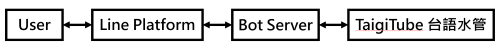

### 使用的技術  

| 技術項目 | 說明 |
|----------|------|
| 程式語言 | Python |
| 框架 | Flask（建立 webhook） |
| 部署平台 | Versel |
| API 使用 |LINE Messaging API（對話） |
| 爬蟲 | 使用 requests 進行爬蟲 |
| 資料格式 | JSON 處理傳輸與接收資料 |

## 專案成果與效益

### 系統程式

In [ ]:
### 安裝函式庫 ###
import os
from flask import Flask, request, abort

from linebot.v3 import WebhookHandler
from linebot.v3.exceptions import InvalidSignatureError
from linebot.v3.webhooks import MessageEvent, TextMessageContent
from linebot.v3.messaging import (
    Configuration, ApiClient, MessagingApi,
    ReplyMessageRequest,
    TextMessage
)
import requests

from linebot.v3 import WebhookHandler
from linebot.v3.exceptions import InvalidSignatureError
from linebot.v3.webhooks import MessageEvent, TextMessageContent
from linebot.v3.messaging import (
    Configuration, ApiClient, MessagingApi,
    ReplyMessageRequest,
    TextMessage,
    TemplateMessage, ConfirmTemplate, MessageAction,
    CarouselTemplate, CarouselColumn, URIAction, PostbackAction
)

import json
import random



### Crawler ###

def crawler(search_word):
  url = "https://taigitube.com/api/search"

  headers = {
      "User-Agent": "Mozilla/5.0",
      "Accept": "application/json",
      "Content-Type": "application/json",
      "Origin": "https://taigitube.com",
      "Referer": "https://taigitube.com/",
  }

  # 注意：只需要這三個欄位（過多反而會錯）
  payload = {
      "query": search_word,  # 搜尋關鍵字
      "v": "",          # 可以留空
      "t": "0"          # 通常是影片時間篩選參數
  }

  response = requests.post(url, headers=headers, json=payload).json()

  reply = []
  # 如果 response 超過10個就隨機取出10個 (LineBot templete 最多只能10個)
  if len(response) > 10:
    response = random.sample(response, 10)

  for r in response:
    #print(r['video_name'])
    #print(r['transcript'])
    yt_url = 'https://youtu.be/watch?v=' + str(r['video_id']) + '&t=' + str(r['start_second']) + 's'
    photo_url = 'https://i.ytimg.com/vi/' + str(r['video_id']) + '/hqdefault.jpg'
    #print(yt_url)
    #print(photo_url)

    reply.append([r['video_name'], r['transcript'], yt_url, photo_url])


  return reply



### Line Bot ###

app = Flask(__name__)

configuration = Configuration(access_token=os.getenv('LINE_CHANNEL_ACCESS_TOKEN'))
line_handler = WebhookHandler(os.getenv('LINE_CHANNEL_SECRET'))

@app.route('/')
def index():
    return 'TaigiTube LINE Bot is running!'

@app.route("/callback", methods=['POST'])
def callback():
    signature = request.headers['X-Line-Signature']
    body = request.get_data(as_text=True)
    try:
        line_handler.handle(body, signature)
    except InvalidSignatureError:
        abort(400)
    return 'OK'


@line_handler.add(MessageEvent, message=TextMessageContent)
def handle_message(event):
    with ApiClient(configuration) as api_client:
        line_bot_api = MessagingApi(api_client)


        data = crawler(event.message.text)
        print(data)

        template_list = []
        for d in data:
            template_list.append(
                CarouselColumn(
                    thumbnail_image_url = d[3],
                    title = d[0],
                    text = d[1][:60],
                    actions=[
                        URIAction(label = '「' + d[0] + '」的「' + event.message.text + '」怎麼講', uri = d[2])
                    ]
                )
            )
        reply = TemplateMessage(
            alt_text = '「' + event.message.text + '」怎麼講',
            template = CarouselTemplate(columns = template_list)
        )


        line_bot_api.reply_message(
            ReplyMessageRequest(
                reply_token=event.reply_token,
                messages=[
                    reply
                ]
            )
        )


if __name__ == "__main__":
    app.run()

### 系統畫面

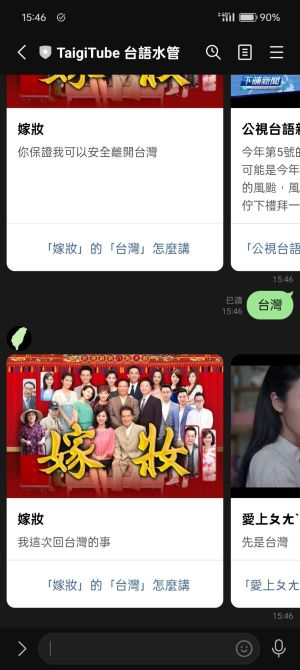

- 使用者於 LINE 傳送訊息：「台灣」  
- LINE Bot 回應：CarouselTemplate，包含10張卡片，每張卡片內容包含戲劇名稱、台詞、YouTube影片連結(已設定好該台詞時間點)、該YouTube影片縮圖

### 效益分析

- 使用者測試報告

| 測試項目 | 測試結果 | 備註 |
|----------|----------|------|
| 功能完整性 | 90% 滿意 | 已抓取網站所有可顯示內容，但若該網站沒有資料則無法顯示 |
| 界面設計 | 100% 滿意 | 界面簡潔明確 |
| 性能表現 | 略有延遲，但可接受 | 爬蟲略為消耗時間 |
| 使用者滿意度 | 平均 5/5 | 跟上潮流、有趣 |
| 建議回饋 | 加入例外處理 | 網站無資料時提醒使用者 |

- 系統是否達到目標？  
是。系統成功讓使用者透過 Line Bot 獲取 [TaigiTube 台語水管](https://taigitube.com/) 資料並顯示，符合預期成果。

## 未來發展與改進

### 改進建議  
- 加入例外處理，網站無資料時提醒使用者。
- 透過語音生成式 AI 獲得其他語言的發音以及更完整的資料庫。

### 未來規劃  
- 整合語音生成式 AI  
- 支援語音輸入